# Support dataset

Move this notebook to the root directory to run it

In [1]:
import numpy as np
# import torch
import argparse
import sys
import pickle
import pandas as pd
from lifelines import CoxPHFitter
import torchtuples as tt
import yaml 
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from copy import deepcopy

from coxkan import CoxKAN
from coxkan.datasets import gbsg, metabric, support, nwtco, flchain
from coxkan.utils import FastCoxLoss, count_parameters, bootstrap_metric, set_seed

SEED = set_seed(42)
exp_name = 'support'
results = {'CoxKAN': {}, 'CoxPH': {}}

output_dir = Path('checkpoints') / exp_name
output_dir.mkdir(parents=True, exist_ok=True)

# load dataset
df_train, df_test = support.load(split=True)
dataset_name, duration_col, event_col, covariates = support.metadata()
assert dataset_name == exp_name

with open(f'configs/coxkan/{exp_name}.yml', 'r') as f:
    config = yaml.safe_load(f)

with open(output_dir / 'config.yml', 'w') as f:
    yaml.dump(config, f)

# Init
ckan = CoxKAN(seed=SEED, **config['init_params'])
coxkan_params = count_parameters(ckan)

# pre-process and register the data with the CoxKAN object
df_train, df_test = ckan.process_data(df_train, df_test, duration_col, event_col, normalization='standard')

# validation set for early stopping
assert config['train_params']['early_stopping'] == True
train, val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train[event_col])


Using default train-test split (used in DeepSurv paper).


train loss: 2.84e+00 | val loss: 2.58e+00: 100%|████████████████████| 20/20 [00:03<00:00,  5.74it/s]


Best model loaded (early stopping).


train loss: 2.83e+00 | val loss: 2.58e+00: 100%|██████████████████| 500/500 [01:29<00:00,  5.60it/s]


Best model loaded (early stopping).
Saved model to checkpoints/support/model.pt
0.6244819034989587


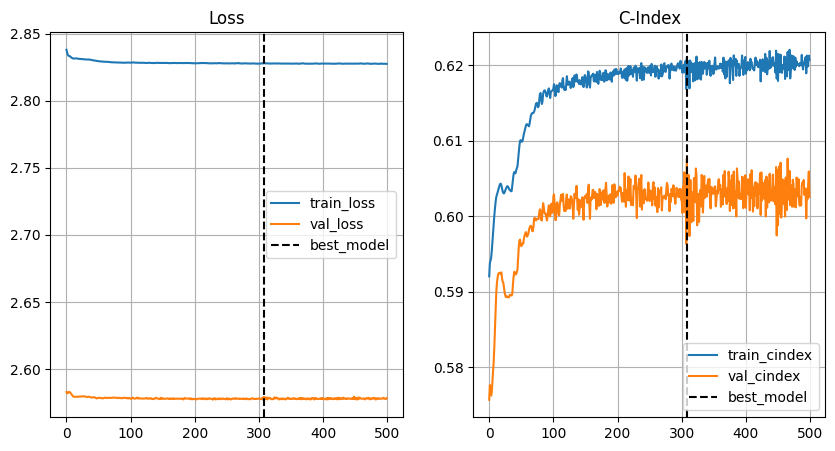

In [2]:
# Warm-up (reduces bugs)
config_warmup = deepcopy(config)
config_warmup['train_params']['steps'] = 20
log = ckan.train(train, val, duration_col, event_col, **config_warmup['train_params'])

# Main training run
log = ckan.train(train, val, duration_col, event_col, **config['train_params'])

ckan.predict(df_test)
ckan.save_ckpt(output_dir / 'model.pt')
fig = log.plot()
fig.savefig(output_dir / 'coxkan_training.png')

print(ckan.cindex(df_test))

CoxKAN - train: 0.618341 (0.617, 0.619), test: 0.624482 (0.622, 0.625)


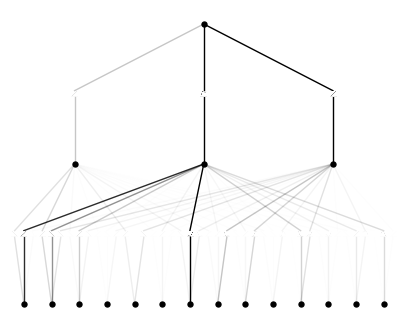

In [3]:
cindex_train = bootstrap_metric(ckan.cindex, df_train, N=100)['formatted']
cindex_test = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']

ckan_pre_str = f'CoxKAN - train: {cindex_train}, test: {cindex_test}'; print(ckan_pre_str)
results['CoxKAN']['Pre'] = {'train': cindex_train, 'test': cindex_test, 'n_params': coxkan_params}

fig = ckan.plot(beta=60, folder=f'./activations/{exp_name}_pre')
fig.savefig(output_dir / 'coxkan_pre.png')

In [4]:
# ckan = CoxKAN(seed=SEED, **config['init_params'])
# ckan.load_ckpt(output_dir / 'model.pt')
# ckan.predict(df_test)

In [5]:
ckan = ckan.prune_nodes(config['prune_threshold'])
_ = ckan.predict(df_test)
ckan.prune_edges(config['prune_threshold'], verbose=True)
_ = ckan.predict(df_test)


Pruned activation (0,4,1)
Pruned activation (0,10,0)
Pruned activation (0,13,0)


CoxKAN (pruned) - train: 0.618338 (0.617, 0.620), test: 0.624485 (0.622, 0.625)


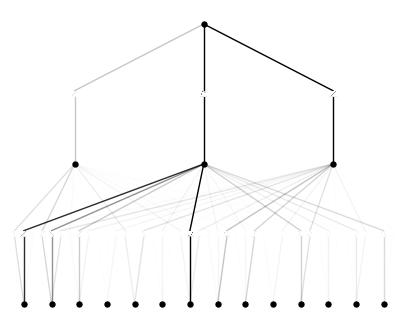

In [6]:
fig = ckan.plot(beta=60, folder=f'./activations/{exp_name}_pruned')
fig.savefig(output_dir / 'coxkan_pruned.png')
cindex_train = bootstrap_metric(ckan.cindex, df_train, N=100)['formatted']
cindex_pruned = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']

ckan_pru_str = f'CoxKAN (pruned) - train: {cindex_train}, test: {cindex_pruned}'; print(ckan_pru_str)
results['CoxKAN']['Pruned'] = {'train': cindex_train, 'test': cindex_pruned}

Using default train-test split (used in DeepSurv paper).


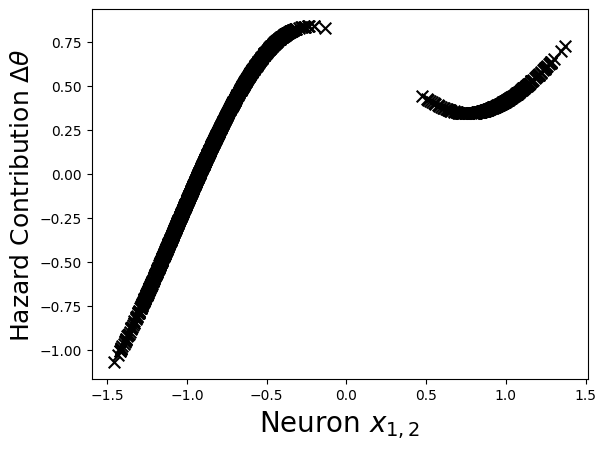

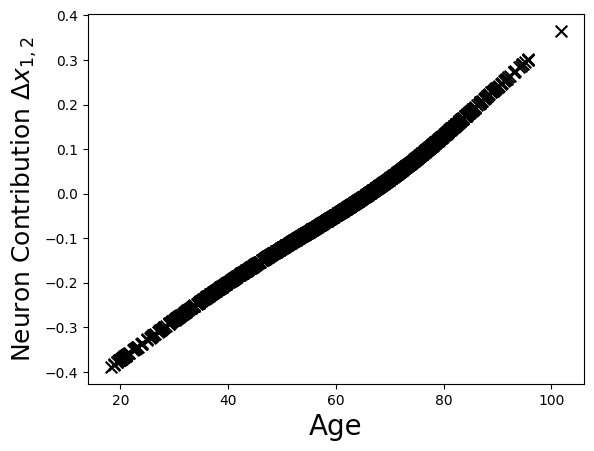

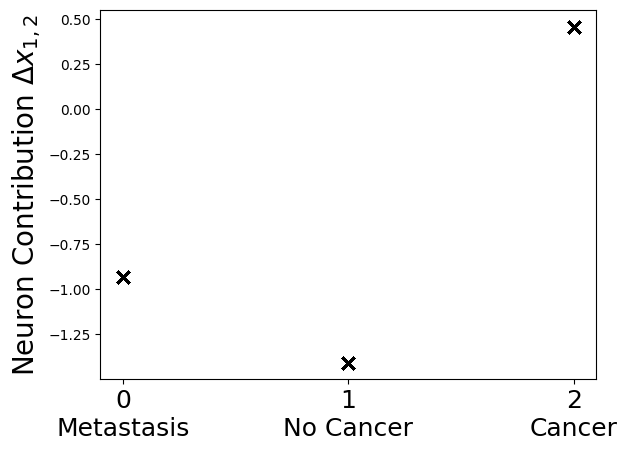

In [7]:
df_train_unnorm, df_test_unnorm = support.load(split=True)

l, i, j = 1, 1, 0
inputs = ckan.spline_preacts[l][:,j,i]
outputs = ckan.spline_postacts[l][:,j,i]
fig, ax = plt.subplots()
ax.scatter(inputs, outputs, marker='x', s=70, color='black')
ax.set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=18)
ax.set_xlabel(r'Neuron $x_{1,2}$', fontsize=20)
fig.savefig(output_dir / f'({l},{i},{j}).png', bbox_inches='tight')

l, i, j = 0, 0, 1
inputs = df_test_unnorm[covariates[i]].values
outputs = ckan.spline_postacts[l][:,j,i]
fig, ax = plt.subplots()
ax.scatter(inputs, outputs, marker='x', s=70, color='black')
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel(r'Neuron Contribution $\Delta x_{1,2}$', fontsize=18)
fig.savefig(output_dir / f'({l},{i},{j}).png', bbox_inches='tight')

l, i, j = 0, 6, 1
inputs = df_test_unnorm[covariates[i]].values   
outputs = ckan.spline_postacts[l][:,j,i]
fig, ax = plt.subplots()
ax.scatter(inputs, outputs, marker='x', s=70, color='black')
# ax.set_xlabel('Cancer Status', fontsize=16)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['0\nMetastasis', '1\nNo Cancer', '2\nCancer'], fontsize=18)
ax.set_ylabel(r'Neuron Contribution $\Delta x_{1,2}$', fontsize=20)
fig.savefig(output_dir / f'({l},{i},{j}).png', bbox_inches='tight')

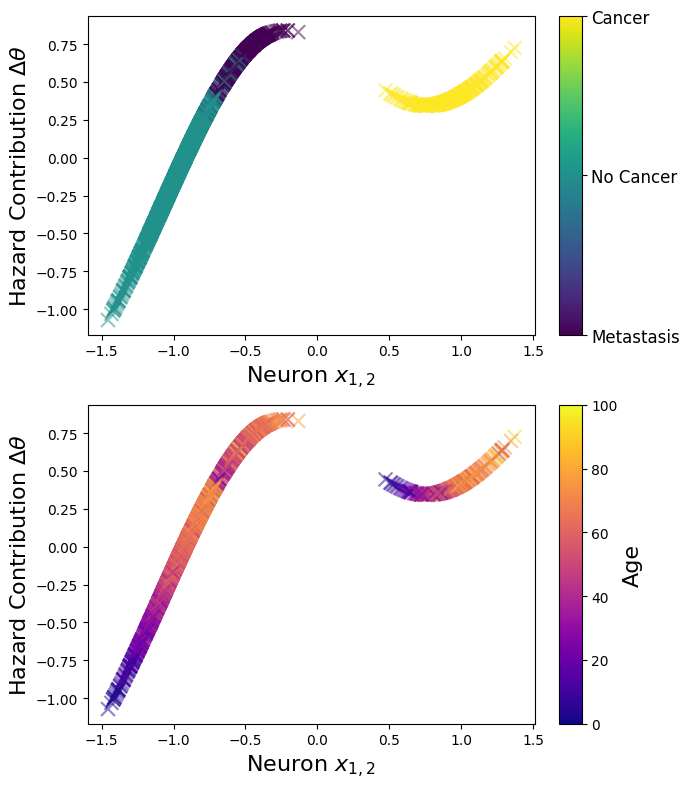

In [8]:
from matplotlib.gridspec import GridSpec

l, i, j = 1, 1, 0
inputs = ckan.spline_preacts[l][:,j,i]
outputs = ckan.spline_postacts[l][:,j,i]

# Create a figure with GridSpec
fig = plt.figure(figsize=(7, 8))
gs = GridSpec(2, 2, width_ratios=[1, 0.05], height_ratios=[1, 1], figure=fig)

# Create subplots
ax0 = fig.add_subplot(gs[0])
ax0.set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=16)
ax0.set_xlabel(r'Neuron $x_{1,2}$', fontsize=16)
cax0 = fig.add_subplot(gs[1])

ax1 = fig.add_subplot(gs[2])
ax1.set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=16)
ax1.set_xlabel(r'Neuron $x_{1,2}$', fontsize=16)
cax1 = fig.add_subplot(gs[3])

# Scatter plots
sc0 = ax0.scatter(inputs, outputs, c=df_test_unnorm['cancer'], cmap='viridis', alpha=0.5, marker='x', s=100)
sc1 = ax1.scatter(inputs, outputs, c=df_test_unnorm['age'], cmap='plasma', alpha=0.5, marker='x', s=100)

# Create a colorbar for the first subplot
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=2))
sm._A = []
cbar = plt.colorbar(sm, cax=cax0)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(['Metastasis', 'No Cancer', 'Cancer'], fontsize=12)

# Create a colorbar for the second subplot
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=100))
sm._A = []
cbar = plt.colorbar(sm, cax=cax1)
cbar.set_label('Age', fontsize=16)

plt.tight_layout()

fig.savefig(output_dir / f'colourplots.png')

no cancer - hazard is lower, and learly increasing with age.

metastatic cancer - hazard is high, increasing with age, but non-linearly.

cancer - hazard is high, initially decreases with age, then increases with age. 

### Symbolic fitting

There is no appropriate symbolic form for the interaction activation function. We perform normaly symbolic fitting on all others.

In [9]:
from coxkan.utils import SYMBOLIC_LIB

### Symbolic Fitting

# Initial symbolic fitting (categorical covariates and linear activations)
ckan.predict(df_test)
for l in range(ckan.depth):
    for i in range(ckan.width[l]):
        for j in range(ckan.width[l+1]):
            if ckan.symbolic_fun[l].mask[j, i] == 0:
                if l == 0 and hasattr(ckan, 'categorical_covariates') and ckan.covariates[i] in ckan.categorical_covariates:
                    ckan.fix_symbolic(l,i,j,'categorical')
                else:
                    # try linear fit (accept if R2 > 0.95)
                    _, _, r2 = ckan.suggest_symbolic(l,i,j,lib=['x'], verbose=False)
                    if r2 > 0.95:
                        ckan.fix_symbolic(l,i,j,'x',verbose=False)
                        print(f'Fixed ({l},{i},{j}) as linear')

Fixed (0,0,0) as linear
Fixed (0,0,1) as linear
Fixed (0,0,2) as linear
Fixed (0,2,0) as linear
Fixed (0,2,1) as linear
Fixed (0,2,2) as linear
Fixed (0,3,0) as linear
Fixed (0,3,1) as linear
Fixed (0,3,2) as linear
Fixed (0,7,0) as linear
Fixed (0,7,1) as linear
Fixed (0,8,0) as linear
Fixed (0,8,1) as linear
Fixed (0,9,0) as linear
Fixed (0,9,1) as linear
Fixed (0,11,0) as linear
Fixed (0,11,2) as linear
Fixed (0,12,0) as linear
Fixed (0,12,1) as linear
Fixed (0,13,2) as linear
Fixed (1,0,0) as linear
Fixed (1,2,0) as linear


In [10]:
from coxkan.utils import SYMBOLIC_LIB

lib = list(SYMBOLIC_LIB.keys()).copy()
ckan.auto_symbolic(min_r2=0, lib=lib, verbose=True)

skipping (0,0,0) since already symbolic
skipping (0,0,1) since already symbolic
skipping (0,0,2) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,1,1) since already symbolic
skipping (0,1,2) since already symbolic
skipping (0,2,0) since already symbolic
skipping (0,2,1) since already symbolic
skipping (0,2,2) since already symbolic
skipping (0,3,0) since already symbolic
skipping (0,3,1) since already symbolic
skipping (0,3,2) since already symbolic
skipping (0,4,0) since already symbolic
skipping (0,4,1) since already symbolic
skipping (0,4,2) since already symbolic
skipping (0,5,0) since already symbolic
skipping (0,5,1) since already symbolic
skipping (0,5,2) since already symbolic
skipping (0,6,0) since already symbolic
skipping (0,6,1) since already symbolic
skipping (0,6,2) since already symbolic
skipping (0,7,0) since already symbolic
skipping (0,7,1) since already symbolic
fixing (0,7,2) with gaussian, r2=0.9559837960084638
skipping (0,8,0) since alrea

True

In [11]:
ckan.unfix_symbolic(1,1,0)
ckan.unfix_symbolic(0,0,1)
ckan.unfix_symbolic(0,6,1)

In [12]:
ckan.cindex(df_test)

0.6237545967829091

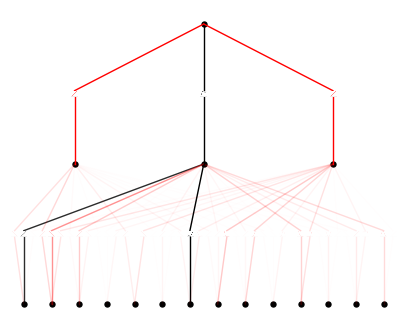

In [13]:
fig = ckan.plot(beta=60, folder=f'./activations/{exp_name}_highlight')
fig.savefig(output_dir / 'coxkan_highlight.png', dpi=600)

In [14]:
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(cindex_symbolic)

0.623755 (0.623, 0.626)


In [15]:
ckan_sym_str = f'CoxKAN (symbolic) - test: {cindex_symbolic}'; print(ckan_sym_str)

results['CoxKAN']['Symbolic'] = {'test': cindex_symbolic}
with open(output_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)

# save c-index results to txt file too
with open(output_dir / 'cindex.txt', 'w') as f:
    f.write(ckan_pre_str + '\n')
    f.write(ckan_pru_str + '\n')
    f.write(ckan_sym_str + '\n')

CoxKAN (symbolic) - test: 0.623755 (0.623, 0.626)


In [16]:
### Getting symbolic form for the rest of the model
ckan.fix_symbolic(1,1,0, '0')
ckan.fix_symbolic(0,0,1, '0')
ckan.fix_symbolic(0,6,1, '0')
formula = ckan.symbolic_formula(floating_digit=4)[0][0]
results['CoxKAN']['Symbolic']['formula'] = formula
with open(output_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)
formula

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.


-0.0002*age + 0.0388*comorbidity + 0.0027*creatinine - 0.0126*race + 0.0008*sodium + 0.0385*Piecewise((-0.0046, Eq(sex, 0)), (0.0059, Eq(sex, 1.0)), (nan, True)) + 0.0385*Piecewise((-0.0018, Eq(diabetes, 0)), (0.0071, Eq(diabetes, 1.0)), (nan, True)) + 0.0385*Piecewise((-0.0004, Eq(dementia, 0)), (0.0124, Eq(dementia, 1.0)), (nan, True)) + 2.4587*Piecewise((-0.0003, Eq(dementia, 0)), (0.0112, Eq(dementia, 1.0)), (nan, True)) + 2.4587*Piecewise((0.0027, Eq(diabetes, 0)), (-0.0112, Eq(diabetes, 1.0)), (nan, True)) + 2.4587*Piecewise((0.0031, Eq(sex, 0)), (-0.004, Eq(sex, 1.0)), (nan, True)) + 2.4587*Piecewise((0.0011, Eq(cancer, 0)), (-0.0047, Eq(cancer, 1.0)), (-0.0039, Eq(cancer, 2.0)), (nan, True)) + 0.0385*Piecewise((0.0041, Eq(cancer, 0)), (-0.0013, Eq(cancer, 1.0)), (-0.0054, Eq(cancer, 2.0)), (nan, True)) - 0.0608*sin(0.0758*rr + 0.2165) + 0.0337*tan(0.0238*wbc - 3.8857) + 0.1155*tanh(0.0224*hr - 2.6734) - 0.7124 + 0.5523*exp(-572.2693*(1 - 0.0244*temp)**2) + 0.866*exp(-0.0561*(1 

# Verifying observed trend with CoxPH

In [17]:
from coxkan.datasets import support 
from lifelines import CoxPHFitter

df = support.load(split=False)

df_nocancer = df[df['cancer'] == 1]

cph = CoxPHFitter()
cph.fit(df_nocancer[['age', 'duration', 'event']], duration_col='duration', event_col='event')
print('No Cancer')
print(cph.summary['coef'].item())

df_metastatis = df[df['cancer'] == 0]

cph = CoxPHFitter()
cph.fit(df_metastatis[['age', 'duration', 'event']], duration_col='duration', event_col='event')
print('\nMetastatis')
print(cph.summary['coef'].item())

df_cancer = df[df['cancer'] == 2]

df_young = df_cancer[df_cancer['age'] < 60]

cph = CoxPHFitter()
cph.fit(df_young[['age', 'duration', 'event']], duration_col='duration', event_col='event')
print('\nYounger than 60, with cancer')
print(cph.summary['coef'].item())

df_old = df_cancer[df_cancer['age'] >= 60]

cph = CoxPHFitter()
cph.fit(df_old[['age', 'duration', 'event']], duration_col='duration', event_col='event')
print('\nOlder than 60, with cancer')
print(cph.summary['coef'].item())

with open(output_dir / 'cph_verify.txt', 'w') as f:
    f.write('No Cancer\n')
    f.write(str(cph.summary['coef'].item()) + '\n')
    f.write('\nMetastatis\n')
    f.write(str(cph.summary['coef'].item()) + '\n')
    f.write('\nYounger than 60, with cancer\n')
    f.write(str(cph.summary['coef'].item()) + '\n')
    f.write('\nOlder than 60, with cancer\n')
    f.write(str(cph.summary['coef'].item()) + '\n')

No Cancer
0.01787243508432996

Metastatis
0.007892614791729459

Younger than 60, with cancer
-0.004289683730522567

Older than 60, with cancer
0.0034938194108434326


In [18]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
def cph_cindex(df):
    return cph.score(df, scoring_method='concordance_index')
cindex_train = bootstrap_metric(cph_cindex, df_train, N=100)['formatted']
cindex_test = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
coxph_str = f'CoxPH - train: {cindex_train}, test: {cindex_test}'; print(coxph_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(coxph_str + '\n')
results['CoxPH'] = {'train': cindex_train, 'test': cindex_test, 'summary': cph.summary}

with open(output_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)

CoxPH - train: 0.569358 (0.568, 0.570), test: 0.583074 (0.581, 0.585)


### Visualizing some of the non-linear terms

In [19]:
def set_red(ax):
    # Set the colors for the axes, labels, and tick marks
    ax.spines['bottom'].set_color('red')
    ax.spines['top'].set_color('red') 
    ax.spines['right'].set_color('red')
    ax.spines['left'].set_color('red')
    
    # ax.xaxis.label.set_color('red')
    # ax.yaxis.label.set_color('red')
    
    # ax.tick_params(axis='x', colors='red')
    # ax.tick_params(axis='y', colors='red')
    
    ax.title.set_color('red')

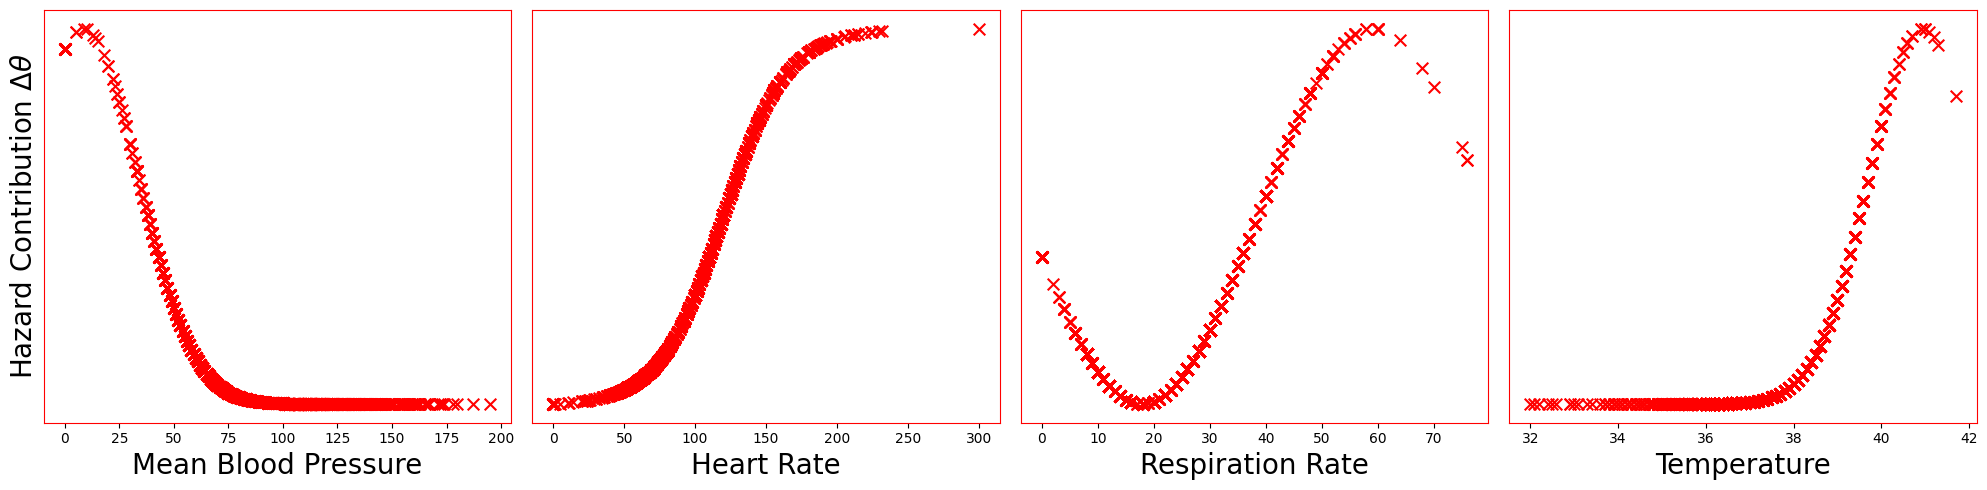

In [20]:
ckan.predict(df_train)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# meanbp
l, i, j = 0, 7, 2
assert ckan.covariates[i] == 'meanbp'
inputs = df_train_unnorm[covariates[i]].values
outputs = ckan.spline_postacts[l][:,j,i]
axes[0].scatter(inputs, outputs, marker='x', s=70, color='red')
axes[0].set_yticks([])
axes[0].set_xlabel('Mean Blood Pressure', fontsize=20)
axes[0].set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=20)
set_red(axes[0])

# heart rate
l, i, j = 0, 8, 2
assert ckan.covariates[i] == 'hr'
inputs = df_train_unnorm[covariates[i]].values
outputs = ckan.spline_postacts[l][:,j,i]
axes[1].scatter(inputs, outputs, marker='x', s=70, color='red')
axes[1].set_yticks([])
axes[1].set_xlabel('Heart Rate', fontsize=20)
set_red(axes[1])

# Respiration rate
l, i, j = 0, 9, 2
assert ckan.covariates[i] == 'rr'
inputs = df_train_unnorm[covariates[i]].values
outputs = ckan.spline_postacts[l][:,j,i]
axes[2].scatter(inputs, outputs, marker='x', s=70, color='red')
axes[2].set_yticks([])
axes[2].set_xlabel('Respiration Rate', fontsize=20)
set_red(axes[2])

# temp
l, i, j = 0, 10, 2
assert ckan.covariates[i] == 'temp'
inputs = df_train_unnorm[covariates[i]].values
outputs = ckan.spline_postacts[l][:,j,i]
axes[3].scatter(inputs, outputs, marker='x', s=70, color='red')
axes[3].set_yticks([])
axes[3].set_xlabel('Temperature', fontsize=20)
set_red(axes[3])

plt.tight_layout()
fig.savefig(output_dir / 'nonlinear-terms.png')

## Symbolic fitting the interaction term

In [21]:
ckan = CoxKAN(seed=SEED, **config['init_params'])
ckan.load_ckpt(output_dir / 'model.pt')
_ = ckan.predict(df_test)

Loaded model from checkpoints/support/model.pt


In [22]:
from coxkan.utils import fit_params, SYMBOLIC_LIB

l, i, j = 1, 1, 0
x = ckan.spline_preacts[l][:,j,i]
y = ckan.spline_postacts[l][:,j,i]

# they are not ordered yet
rank = np.argsort(x)
x = x[rank]
y = y[rank]

############
# pykan's Auto-symbolic procedure
############
best_fn, _, r2 = ckan.suggest_symbolic(l, i, j, verbose=False)
func = SYMBOLIC_LIB[best_fn][0]
(a, b, c, d), r2 = fit_params(x, y, func, a_range=(-10,10), b_range=(-10,10))

y_pykan_pred = c*func(a*x+b)+d

r2 is 0.9419898460035256


In [49]:
from coxkan.utils import add_symbolic 
import torch
import sympy
from pysr import PySRRegressor

############
# PySR symbolic fitting
############

default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

# Learn equations
model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=['exp', 'sin', 'log', 'tanh', 'atan', 'cosh'],
    maxsize=15,
    procs=0,
    # multithreading=False,
    # deterministic=True,
    # random_state=42,
    **default_pysr_params,
)

model.fit(x.reshape(-1,1), y.reshape(-1,1))

sympy.simplify(model.sympy())

display(sympy.simplify(model.sympy()))

y_pysr_pred = model.predict(x.reshape(-1,1))

/Users/willknott/miniconda3/envs/coxkan-env/lib/python3.12/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.680e+04
Progress: 86 / 900 total iterations (9.556%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           8.313e-01  1.594e+01  y = x₀
2           1.872e-01  1.491e+00  y = tanh(0.12737)
4           7.585e-02  4.516e-01  y = sin(x₀ + -11.604)
5           5.560e-02  3.107e-01  y = tanh(sin(x₀ - -0.94261))
6           2.752e-02  7.033e-01  y = sin(1.544 * (x₀ + 0.92549))
7           2.000e-02  3.193e-01  y = tanh(tanh((x₀ + 0.92039) / 0.39987))
8           7.095e-03  1.036e+00  y = tanh(sin(2.4966 * sin(x₀ + 0.92549)))
9           6.904e-03  2.729e-02  y = sin(tanh(sin(2.4966 * sin(x₀ + 0.92549))))
10          4.040e-03  5.359e-01  y = sin(atan(tanh(1.6301) + x₀) / exp(sin(x₀)))
12          3.377e-03  8.957e-02  y = sin((1.4545 - sin(x₀)) * sin(atan(tanh(x₀ + 0.92549))))
13          1.799e-03  6.300e-01  y = (x₀ - sin(x₀ + (atan(-0.89097)

x0 - sin(x0 + tanh(sin(x0 + 0.24456245)) - 0.83578277) + 0.19245872

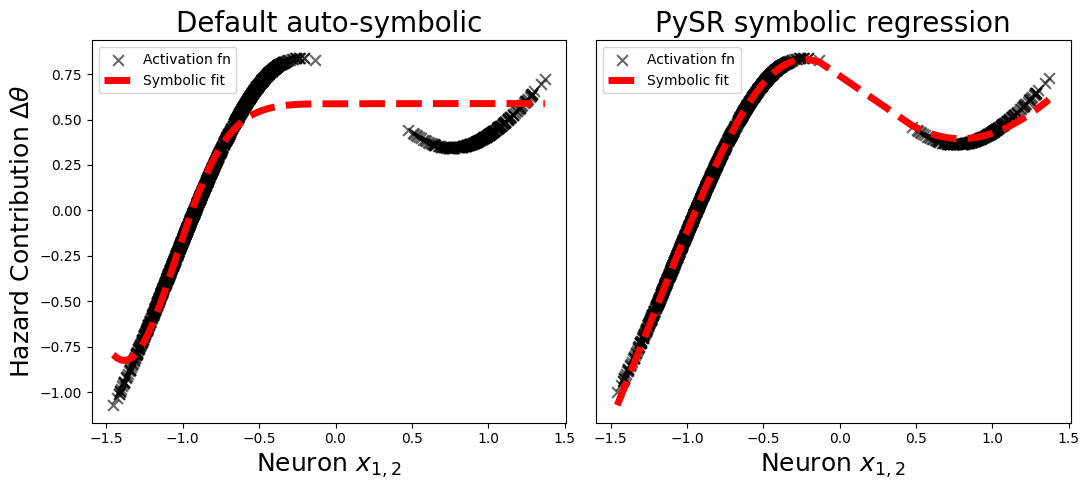

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

axes[0].scatter(x, y, marker='x', s=60, color='black', alpha=0.6, label='Activation fn')
axes[0].plot(x, y_pykan_pred, color='red', linestyle='--', linewidth=5, label='Symbolic fit')
axes[0].set_xlabel(r'Neuron $x_{1,2}$', fontsize=18)
axes[0].set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=18)
axes[0].set_title('Default auto-symbolic', fontsize=20)
axes[0].legend(loc="upper left")

axes[1].scatter(x, y, marker='x', s=60, color='black', alpha=0.6, label='Activation fn')
axes[1].plot(x, y_pysr_pred, color='red', linestyle='--', linewidth=5, label='Symbolic fit')
axes[1].set_xlabel(r'Neuron $x_{1,2}$', fontsize=18)
axes[1].set_title('PySR symbolic regression', fontsize=20)
axes[1].set_yticks([])
axes[1].legend(loc="upper left")

plt.tight_layout()

fig.savefig(output_dir / 'symbolic-fitting.png', dpi=600)

In [ ]:
# # How we can add this symbolic function to the model
# from coxkan.utils import add_symbolic 
# import torch

# torch_fn = lambda x: torch.sin(x - (torch.sin(x + torch.arctan(x) - 0.7470143) - 0.2648517))
# sympy_fn = lambda x: sympy.sin(x - (sympy.sin(x + sympy.atan(x) - 0.7470143) - 0.2648517))

# add_symbolic('age_cancer_interaction', torch_fn, sympy_fn)

# r2 = ckan.fix_symbolic(1,1,0,'age_cancer_interaction')
# print(f'(1,1,0) Activation age_cancer_interaction fit with R^2: {r2}')
# r2 = ckan.fix_symbolic(0,0,1,'x')
# print(f'(0,0,1) Activation x fit with R^2: {r2}')
# r2 = ckan.fix_symbolic(0,6,1,'categorical')
# print(f'(0,6,1) Activation categorical fit with R^2: {r2}')

# ckan.cindex(df_test)